# AWS fine-tuning Resnet 18 for image classification using SageMaker

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.

This project is part of the AWS Machine Learning Engineer Nanodegree requisites. It consists in the fine-tuning of a pretrained big image classification model (Resnet 18) using SageMaker, the main AWS tool for machine learning developing and deploying. The project will re train the last fully connected layer of the model with a new set of images from https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip, that consists in dozens of different images of dog breeds, labeled with the corresponding dog's breed. Then we will test the accuracy of the model in recognizing different breeds.
In the process of getting this job done, we will perform a search of best hyperparameteres and monitorize the re-training of the model by using the Sagemaker hyperparameter tuner, profiler and debugger.

In [2]:
# This package gets lost each time we restart the session
# So it must be rerun for each session
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

from sagemaker.session import Session
from sagemaker import get_execution_role

role=get_execution_role()
sagemaker_session=sagemaker.Session()
region=sagemaker_session.boto_region_name
bucket=sagemaker_session.default_bucket()

## Dataset
In this cell we download the zip file containing the images ditributed in three subdirectories: train (train set) valid (validation set) test (test set)

Within those dirs there are sub folders with a number and a name of the dog's breed images it contain. Those directory names will serve as labels for our images.

The !(bang sign) means execute a command in console First, we download the file by using the wget linux command Second, we unzip the file by using the zip linux command

These folders with images go to newly created folders into the file system of the machine that SageMaker is using. Then, another command, aws performs the copy from the local machine file system to the s3 resource of our AWS account. Those files in S3 are ready to be consumed by our model, provided the rol we asigned to the SageMaker session has rights to read/write over our S3 resource.

In [8]:
#TODO: Fetch and upload the data to AWS S3
# run once only
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip > /dev/null
;

--2022-02-13 15:34:20--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.216
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  46.6MB/s    in 30s     

2022-02-13 15:34:53 (35.5 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



''

In [7]:
prefix = "dogImages"
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)

''

In [4]:
inputs = 's3://sagemaker-us-east-1-189666338566/dogImages/'

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import(
CategoricalParameter,
ContinuousParameter,
HyperparameterTuner,
IntegerParameter)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "epochs": IntegerParameter(2, 4),
    "batch_size": CategoricalParameter([16, 32, 64, 128]),
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [6]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch


estimator = PyTorch(
entry_point="hpo.py",
base_job_name="image_classification",
role=role,
instance_count=1,
instance_type = "ml.m5.large",
py_version = "py36",
framework_version = "1.8"
)

tuner = HyperparameterTuner(
estimator,
objective_metric_name,
hyperparameter_ranges,
metric_definitions,
max_jobs=4,
max_parallel_jobs=2,
objective_type=objective_type, 
early_stopping_type="Auto"
)

In [35]:
# TODO: Fit your HP Tuner
tuner.fit({"training":inputs},wait=True) # TODO: Remember to include your data channels

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................!
2.037925101000001


In [36]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

2.0483532660000012

2022-01-17 19:47:15 Starting - Preparing the instances for training
2022-01-17 19:47:15 Downloading - Downloading input data
2022-01-17 19:47:15 Training - Training image download completed. Training in progress.
2022-01-17 19:47:15 Uploading - Uploading generated training model
2022-01-17 19:47:15 Completed - Training job completed
Best hyperparameters from hpo:
lr: 0.0018904851697260853
batch_size: 16
epochs: 2


In [7]:
#Best hyperparameters from hpo to avoid re-running previous jobs
best_para = {'_tuning_objective_metric': 'average test loss',
 'batch_size': '64',
 'epochs': '3',
 'lr': '0.0002443437553814109',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': 'PyTorch',
 'sagemaker_estimator_module': 'sagemaker.pytorch.estimator',
 'sagemaker_job_name': 'image_classification-2022-02-13-06-26-58-463',
 'sagemaker_program': 'hpo.py',
 'sagemaker_region': 'us-east-1',
 'sagemaker_submit_directory': 's3://sagemaker-us-east-1-189666338566/image_classification-2022-02-13-06-26-58-463/source/sourcedir.tar.gz'}

## Model Profiling and Debugging
Using the best hyperparameters, create and finetune a new model

**Note:** We will need to use the `train_model.py` script to perform model profiling and debugging.

In [8]:
# TODO: Set up debugging and profiling rules and hooks
#https://knowledge.udacity.com/questions/756730 dijeron la sugerencia del mentor.

from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import (
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config=ProfilerConfig(
system_monitor_interval_millis=500,framework_profile_params=FrameworkProfile(num_steps=10))
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [9]:
# TODO: Create and fit an estimator
estimator = PyTorch(
entry_point="train_model.py",
instance_count=1,
instance_type="ml.m5.large",
role=role,
framework_version="1.8", 
py_version="py36",
hyperparameters=best_para,
profiler_config=profiler_config,
debugger_hook_config=debugger_config, 
rules=rules
)

estimator.fit({'train' : inputs },wait=True)

2022-02-13 16:36:08 Starting - Starting the training job...
2022-02-13 16:36:30 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-02-13 16:38:02 Downloading - Downloading input data...............
2022-02-13 16:40:32 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-13 16:40:22,702 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-13 16:40:22,705 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-02-13 16:40:22,719 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-13 16:40:22,727 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-13 16:40:

In [10]:
#Saving for later
model_data_saved = estimator.model_data
print("Model artifact saved at:\n", model_data_saved)

import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")


Model artifact saved at:
 s3://sagemaker-us-east-1-189666338566/pytorch-training-2022-02-13-16-36-07-306/output/model.tar.gz
Training jobname: pytorch-training-2022-02-13-16-36-07-306
Region: us-east-1


In [11]:
# TODO: Plot a debugging output.
#for checking training behavior
#From 4.8.SageMaker Debugger.rtfd
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

[2022-02-13 19:01:03.173 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:1103 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-02-13 19:01:03.206 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:1103 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-189666338566/pytorch-training-2022-02-13-16-36-07-306/debug-output
[2022-02-13 19:01:03.951 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:1103 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-02-13 19:01:05.002 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:1103 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.bias', 'gradient/ResNet_fc.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0

In [12]:
from smdebug import modes
trial.tensor('CrossEntropyLoss_output_0').values(mode=modes.TRAIN)
tensor_name = "CrossEntropyLoss_output_0"
;

''

In [13]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [14]:
# Now the debugging plot.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


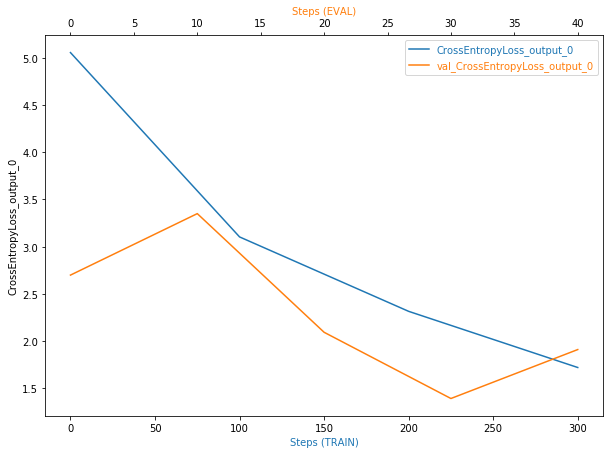

In [15]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it? 

The graph shows no anomalous behavior for different the batch sets. 

**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

A bad behavior would be the blue with erratic behavior or not decreasingwith batches. In that case batches could be shuffled to try to minimize this effect.



In [16]:
# TODO: Display the profiler output

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive


2022-02-13 19:00:43     375313 pytorch-training-2022-02-13-16-36-07-306/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-02-13 19:00:42     223236 pytorch-training-2022-02-13-16-36-07-306/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-02-13 19:00:37        193 pytorch-training-2022-02-13-16-36-07-306/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-02-13 19:00:37        201 pytorch-training-2022-02-13-16-36-07-306/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-02-13 19:00:37       1972 pytorch-training-2022-02-13-16-36-07-306/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-02-13 19:00:37        127 pytorch-training-2022-02-13-16-36-07-306/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-02-13 19:00:37        200 pytorch-training-2022-02-13-16-36-07-306/rule-output/ProfilerReport/profiler-output/profiler-re

In [17]:
import IPython

profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

Reusing code from Part 4 (next part, as mentor suggestion) because of errors on invoking endpoints

In [18]:
# TODO: Deploy your model to an endpoint
testdog = "./dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg"
with open(testdog, "rb") as f:
    payload = f.read()

In [84]:
!pip install torch
!pip install torchvision
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [153]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

#model_data_artifacts = estimator.model_data
#For avoiding waiting:
model_data_artifacts = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
print("Model data artifacts saved at:\n", model_data_artifacts)

#We need to define the serializer and deserializer that we will be using as default for our Prediction purposes
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

#Mentor
#If we need to override the serializer and deserializer 
#then we need to pass them in an class inheriting the 
#Predictor class and pass this class as parameter to our PyTorchModel
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_data_artifacts,
                            role = role,
                             entry_point= "endpoint_inference.py",
                             py_version = "py36",
                             framework_version = "1.6",
                            predictor_cls = ImgPredictor
                            )

# TODO: Add your deployment configuration like instance type and number of instances
#predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.t2.medium")
predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.m5.large")

Model data artifacts saved at:
 s3://sagemaker-us-east-1-265451871023/pytorch-training-2022-01-17-19-55-56-800/output/model.tar.gz
----------!

Test image no: 1
Below is the image that we will be testing:


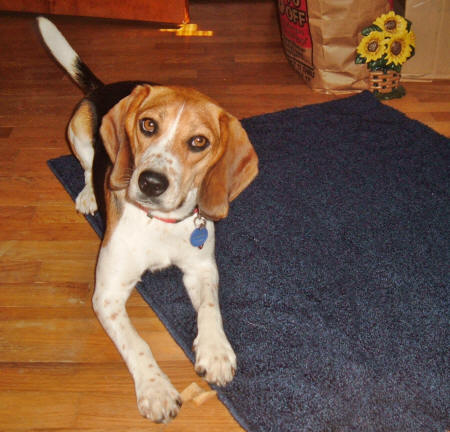

Expected dog breed number: 16
Response: [[-18.62733268737793, -12.707524299621582, -9.216130256652832, -7.795525550842285, -14.295870780944824, -13.699377059936523, -1.121895432472229, -7.585616588592529, -12.71341323852539, -7.508368015289307, -10.568280220031738, -9.496917724609375, -11.076629638671875, -5.51365327835083, -5.71173620223999, -1.1391409635543823, -17.515560150146484, -17.43584632873535, -11.517961502075195, -11.178787231445312, -16.9406681060791, -18.282743453979492, -12.60407543182373, -12.572240829467773, -15.096362113952637, -11.999008178710938, -7.076318264007568, -6.186570167541504, -14.866799354553223, -8.968830108642578, -13.244580268859863, -12.494044303894043, -14.73427963256836, -7.722403526306152, -10.521751403808594, -13.482880592346191, -5.332826614379883, -14.098361015319824, -10.825103759765625, -11.341796875, -9.634931564331055, -14.409683227539062, -11.344259262084961, -12.250977516174316, -10.803894996643066, -7.609820365905762, -10.110761642456055, -

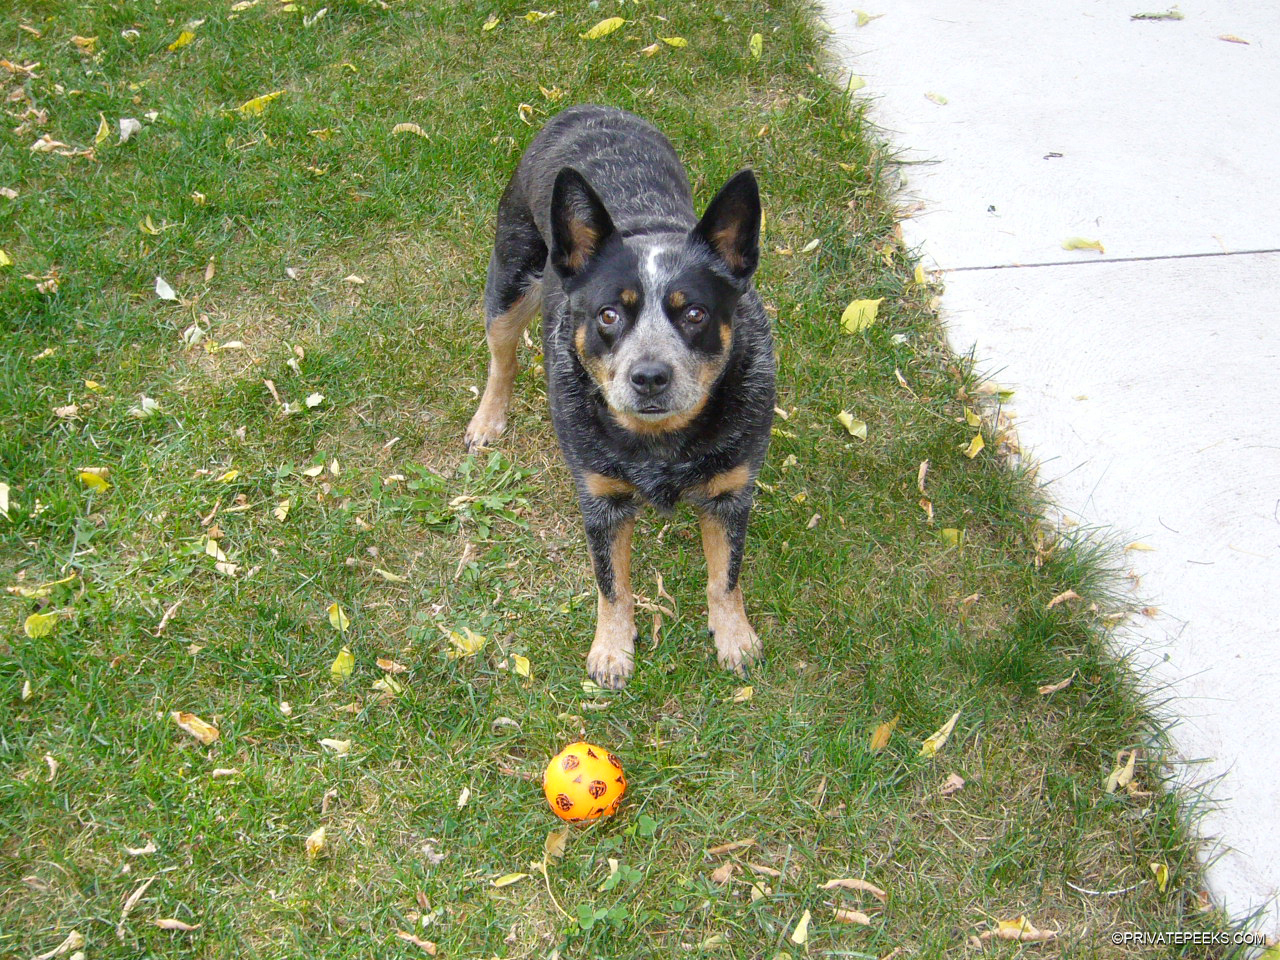

Expected dog breed number: 11
Response: [[-18.052122116088867, -11.846412658691406, -9.941231727600098, -6.735138893127441, -6.738590240478516, -11.17677116394043, -11.468801498413086, -10.601958274841309, -11.069624900817871, -10.260371208190918, -4.272280693054199, -8.39989185333252, -8.754805564880371, -7.260283470153809, -10.52151107788086, -10.159357070922852, -18.581844329833984, -8.734786987304688, -15.375805854797363, -7.939792633056641, -10.207229614257812, -11.31554889678955, -9.056131362915039, -14.972868919372559, -15.26040267944336, -12.18545913696289, -11.375532150268555, -7.263460636138916, -10.521968841552734, -10.422130584716797, -10.941102027893066, -11.483772277832031, -14.292468070983887, -12.760653495788574, -10.876007080078125, -13.397184371948242, -12.99730396270752, -13.6439790725708, -12.352230072021484, -16.630556106567383, -13.219916343688965, -13.891800880432129, -10.921030044555664, -12.148550033569336, -7.4064154624938965, -11.200701713562012, -12.96504020

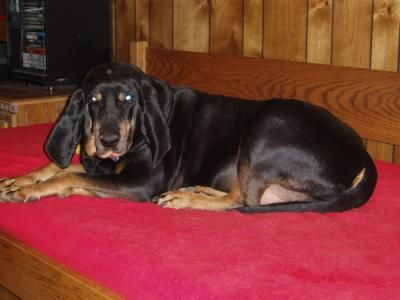

Expected dog breed number: 25
Response: [[-16.170534133911133, -10.785391807556152, -13.031437873840332, -12.15143871307373, -13.800918579101562, -17.775531768798828, -11.650442123413086, -9.808935165405273, -11.131810188293457, -10.27880573272705, -12.563045501708984, -13.230420112609863, -10.988264083862305, -13.366375923156738, -5.425084590911865, -9.656116485595703, -14.76162052154541, -10.278474807739258, -17.54217529296875, -10.956110000610352, -11.961322784423828, -12.508716583251953, -12.159194946289062, -18.426061630249023, -8.601022720336914, -10.759261131286621, -3.634242296218872, -6.206238269805908, -15.813535690307617, -11.544482231140137, -15.118979454040527, -13.00115966796875, -13.85576057434082, -10.413997650146484, -8.773409843444824, -9.992348670959473, -13.106583595275879, -12.475274085998535, -14.596525192260742, -11.74950885772705, -8.40719223022461, -15.099233627319336, -15.858409881591797, -8.188515663146973, -15.651702880859375, -10.793880462646484, -11.982460

In [154]:
# TODO: Run an prediction on the endpoint
# Using the Predictor object directly to evaluate breed
# adapted from udacity forum
from PIL import Image
import io
import os
import numpy as np

test_dir = "./dogImages/test/"
test_images = [ "016.Beagle/Beagle_01130.jpg", '011.Australian_cattle_dog/Australian_cattle_dog_00727.jpg', '025.Black_and_tan_coonhound/Black_and_tan_coonhound_01789.jpg' ]
test_images_expected_output = [16, 11, 25]
for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_breed_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected dog breed number: {expected_breed_category}")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
        print(f"Response: {response}")
        predicted_dog_breed = np.argmax(response,1) + 1 #index starts in 0 and breeds start in 1
        print(f"Response/Inference for the above image is : {predicted_dog_breed}")

In [155]:
# delete the endpoint once work is done as it charges overtime
predictor.delete_endpoint()